<a href="https://colab.research.google.com/github/jufabeck2202/KI-Lab/blob/main/Termin_1_WS2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimieren Übung - Termin 1

In dieser Übung wird ein Kreis an eine verrauschte Punktewolke angepasst. 

Dabei wird im ersten Teil die analytische Lösung zum Berrechnen des Kreismittelpunkts $(m_x,m_y)^T \in \mathbb{R}^2$ bei gegebenem Radius $r \in \mathbb{R}^+$ ermittelt. <br/>
Im zweiten Teil wird eine numerische Lösung für $m_x,m_y$ und $r$ gesucht. Dabei wird im ersten Schritt eine Schätzung analytisch bestimmt.
Diese initiale Lösung wird anschließend mit Hilfe eines Gradientenabstiegsverfahrens optimiert.

## Nötige Imports

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import random

## Teil 1 - Analytische Lösung

Schreiben Sie eine Funktion $\mathit{circlePoint}$ mit

$
M_x, M_y, R, \theta \mapsto 
\begin{pmatrix}
R\cos(\theta) + M_x + \rho_x\\
R\sin(\theta) + M_y + \rho_y
\end{pmatrix}, 
\quad \rho_x,\rho_y \sim N(0,\frac{1}{100}) 
$

Schreiben Sie eine weitere Funktion $\mathit{sampleCirclePointsNoisy}$ welche statt $\theta$ einen Vektor $\Theta \in \mathbb{R}^{1000}$ auf eine Matrix in $\mathbb{R}^{2 \times 1000}$ abbildet. An diese erzeugten Daten wird anschließend ein Kreis angepasst:

In [2]:
def circlePoint(m,r,theta):
  x = m[0]
  y = m[1]
  return np.array([r * np.cos(theta) +x + random.uniform(0, 1/100) ,  r* np.sin(theta) + y + random.uniform(0, 1/100)])

  
def sampleCirclePointsNoisy(m,r,theta):
  my_numbers = []
  for i in theta:
    n = circlePoint(m,r, i)
    my_numbers.append(n)
  return np.array(my_numbers).T

Ziehen sie $1000$ Zahlen gleichverteilt aus $\Theta \sim [0,\frac{\pi}{2}]^{1000}$ und berechnen Sie $\mathit{sampleCirclePointsNoisy}(0,0,2,\Theta)$:

In [3]:
theta = []

for i in range(1000):
  theta.append(random.uniform(0, np.pi/2))

data = sampleCirclePointsNoisy([0,0],2, theta)


Plotten Sie die Punktewolke mit matplotlib:

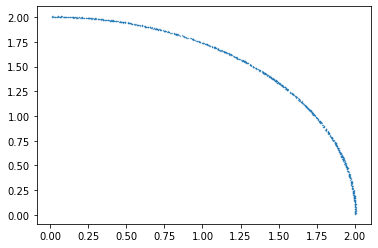

In [4]:
plt.scatter(data[0], data[1],0.1)
plt.show()

Implementieren Sie die Funktion $\mathit{fitCenteredCircle}$ aus den Vorlesungsfolien zur analytischen Bestimmung des Radius $r$ aus der Punktewolke:

*Eigene Anmerkung:* $r = \frac{1}{m} \cdot \sum_{i=1}^m{\sqrt{x_i^2 + y_i^2}}$    

In [5]:
def fitCenteredCircle(data):
    data = data.T
    output = 0.00
    for b in data:
      output += np.sqrt((b[0]**2+b[1]**2))
    return 0, 0, output/len(data)

In [6]:
mx,my,r = fitCenteredCircle(data)

In [7]:
def draw(mx,my,r, data):
    circle1=plt.Circle((mx,my),r,color='r',fill=False)
    axes = plt.gca()
    axes.set_xlim([-3,3])
    axes.set_ylim([-3,3])
    plt.gca().set_aspect('equal', adjustable='box')
    axes.add_artist(circle1)
    plt.scatter(data[0],data[1])
    plt.show()

Plotten Sie Ihre Lösung mit Hilfe der $\mathit{draw}$ Funktion:

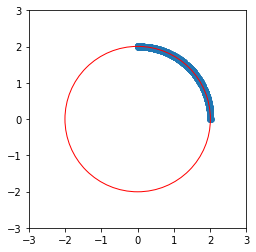

In [8]:
draw(mx, my, r, data)

## Teil 2 - Numerische Lösung

Implementieren Sie eine Funktion $f$, welche die Kosten für beliebige Kreisparameter $m_x,m_y,r$ und Punktewolke $d$ bestimmt:

$f(m_x,m_y,r,d) = \sum_{i=1}^{1000} \left(\sqrt{(m_x - d_{0,i})^2 + (m_y - d_{1,i})^2} - r\right)^2$

In [9]:
def residual(mx,my,r,d): 
    inner_root = np.sqrt(((mx - d[0])**2) + ((my - d[1])**2))
    return (inner_root - r) **2

def f(mx,my,r,d):
    error = 0.0
    for i in d.T:
      error += residual(mx,my,r,i)
    return error

Emitteln Sie die Kosten für Ihre Lösung mit Hilfe von $f$:

In [10]:
f(mx,my,r,data)

0.008839705115199105

Plotten Sie $f(0,0,r,d)$ für $r \in [0,5]$. Was fällt Ihnen auf?

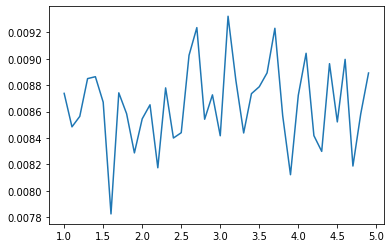

In [54]:
error = []
for i in np.arange(1, 5, 0.1):
  data = sampleCirclePointsNoisy([0,0],2, theta)
  nx,ny,nr = fitCenteredCircle(data)
  error.append([f(nx,ny,nr,data),i])

error = np.array(error).T

plt.plot(error[1], error[0])
plt.show()


Plotten Sie $f(x,y,2,d)$ für $(x,y) \in [-3,5] \times [0,3]$. Was fällt Ihnen auf?

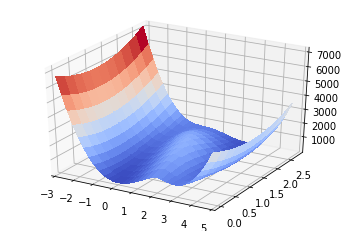

In [53]:
X = np.arange(-3, 5, 0.25)
Y = np.arange(0, 3, 0.25)
X, Y = np.meshgrid(X, Y)
Z = []
for x,y in zip(X.ravel(),Y.ravel()):
    Z += [f(x,y,2,data)]
Z = np.array(Z).reshape(X.shape)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim(left=-3, right=5)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

Implementieren sie eine Funktion $\mathit{grad}$ mit den selben Parametern wie $f$, welche den Gradienten an einer gegebenen Position berechnet:

$\nabla f = (\frac{\partial f}{\partial m_x},\frac{\partial f}{\partial m_y},\frac{\partial f}{\partial r})^T$

In [13]:
def grad(mx,my,r,d):
    #compute gradient    
    return df_dmx,df_dmy,df_dr

Schreiben sie eine Funktion $\mathit{grad\_finite}$, welche $\nabla f$ mit Hilfe des zentralen Differenzenquotienten bestimmt:

$\nabla_h f = \left(\frac{f(m_x+h,m_y,r,d) - f(m_x-h,m_y,r,d)}{2h},\frac{f(m_x,m_y+h,r,d) - f(m_x,m_y-h,r,d)}{2h},\frac{f(m_x,m_y,r+h,d) - f(m_x,m_y,r-h,d)}{2h} \right)^T$

In [14]:
def grad_finite(mx,my,r,d):
    h = 1E-5
    df_dmx = 0#TODO
    df_dmy = 0#TODO
    df_dr = 0#TODO
    dn = np.array([df_dmx,df_dmy,df_dr])
    return dn

Schreiben Sie eine Funktion $\mathit{debugGrad}$, welche $\nabla f$ und $\nabla_{10^{-5}}f$ auf der Konsole ausgibt:

In [15]:
def debugGrad(mx,my,r,d):
    pass

Rufen Sie $\mathit{debugGrad}$ mit verschiedenen Parametern auf um sich der Korrektheit ihrer Implementierung für $\nabla f$ zu versichern:

Schreiben Sie eine Funktion $\mathit{make\_initial\_guess}$, welche eine Punktewolke entgegennimmt und initiale Schätzungen für $m_x, m_y$ und $r$ zurückgibt:

In [16]:
def make_initial_guess(d):
    #TODO
    return mx,my,r

Testen Sie Ihre Funktion und plotten sie Ihre Schätzung mit $\mathit{draw}$:

Implementieren Sie das Gradientenabstiegtsverfahren in einer Funktion $\mathit{solve}$:

In [17]:
def solve(mx,my,r,d):
    pass
    return e,mx,my,r

Führen sie das Gradientenabstiegsverfahren aus und starten Sie mit Ihrer initialen Schätzung. Plotten Sie Ihr Ergebnis mit $\mathit{draw}$:

Optional: Visualisieren Sie die Evolution der Kreisanpassung über die Zeit (Bilderfolge oder Animation).